# ML Experiment-3

Decision Tree on "Infected_Data.csv"

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
data = pd.read_csv("Infected_Data.csv")

X = data.drop(columns=['ID', 'Infected'])
y = data['Infected']

X = X.apply(lambda col: col.astype('category').cat.codes)
y = y.astype('category').cat.codes

In [ ]:
def entropy(y):
    counts = Counter(y)
    probs = [c / len(y) for c in counts.values()]
    return -sum(p * np.log2(p) for p in probs if p > 0)

In [ ]:
def information_gain(y, X_column):
    parent_entropy = entropy(y)
    values = np.unique(X_column)
    weighted_entropy = sum((len(y[X_column == val]) / len(y)) * entropy(y[X_column == val]) for val in values)
    return parent_entropy - weighted_entropy

In [ ]:
def best_split(X, y):
    best_gain, best_feature = -1, None
    for feature in X.columns:
        parent_entropy = entropy(y)
        values = np.unique(X[feature])
        weighted_entropy = sum(
            (len(y[X[feature] == val]) / len(y)) * entropy(y[X[feature] == val])
            for val in values
        )
        gain = parent_entropy - weighted_entropy
        if gain > best_gain:
            best_gain, best_feature = gain, feature
    return best_feature

In [ ]:
def build_tree(X, y, depth=0):
    indent = "  " * depth
    classes = dict(Counter(y))
    node_entropy = round(entropy(y), 3)
    print(f"{indent}Samples: {len(y)}, Classes: {classes}, Entropy: {node_entropy}")

    if len(np.unique(y)) == 1:
        print(f"{indent}--> Leaf: Class {y.iloc[0]}")
        return y.iloc[0]

    if X.shape[1] == 0:
        majority_class = Counter(y).most_common(1)[0][0]
        print(f"{indent}--> Leaf: Majority Class {majority_class}")
        return majority_class

    gains = [information_gain(y, X[col]) for col in X.columns]
    best_feature = X.columns[np.argmax(gains)]
    print(f"{indent}Split on '{best_feature}'")

    tree = {best_feature: {}}
    for val in np.unique(X[best_feature]):
        print(f"{indent}Branch {best_feature} = {val}:")
        mask = X[best_feature] == val
        subtree = build_tree(X[mask].drop(columns=[best_feature]), y[mask], depth + 1)
        tree[best_feature][val] = subtree

    return tree

In [ ]:
def print_tree(tree, indent=""):
    if not isinstance(tree, dict):
        print(indent + "-> " + str(tree))
        return

    for feature, branches in tree.items():
        print(indent + feature + "?")
        for val, subtree in branches.items():
            print(indent + f"|-- {val}")
            print_tree(subtree, indent + "    ")

decision_tree = build_tree(X,y)
print_tree(decision_tree)

Samples: 14, Classes: {0: 6, 1: 8}, Entropy: 0.985
Split on 'Breathing Issues'
Branch Breathing Issues = 0:
  Samples: 6, Classes: {0: 5, 1: 1}, Entropy: 0.65
  Split on 'Fever'
  Branch Fever = 0:
    Samples: 3, Classes: {0: 3}, Entropy: -0.0
    --> Leaf: Class 0
  Branch Fever = 1:
    Samples: 3, Classes: {0: 2, 1: 1}, Entropy: 0.918
    Split on 'Cough'
    Branch Cough = 1:
      Samples: 3, Classes: {0: 2, 1: 1}, Entropy: 0.918
      --> Leaf: Majority Class 0
Branch Breathing Issues = 1:
  Samples: 8, Classes: {1: 7, 0: 1}, Entropy: 0.544
  Split on 'Fever'
  Branch Fever = 0:
    Samples: 3, Classes: {1: 2, 0: 1}, Entropy: 0.918
    Split on 'Cough'
    Branch Cough = 1:
      Samples: 3, Classes: {1: 2, 0: 1}, Entropy: 0.918
      --> Leaf: Majority Class 1
  Branch Fever = 1:
    Samples: 5, Classes: {1: 5}, Entropy: -0.0
    --> Leaf: Class 1
Breathing Issues?
|-- 0
    Fever?
    |-- 0
        -> 0
    |-- 1
        Cough?
        |-- 1
            -> 0
|-- 1
    Fever?
 

<Figure size 1200x700 with 0 Axes>

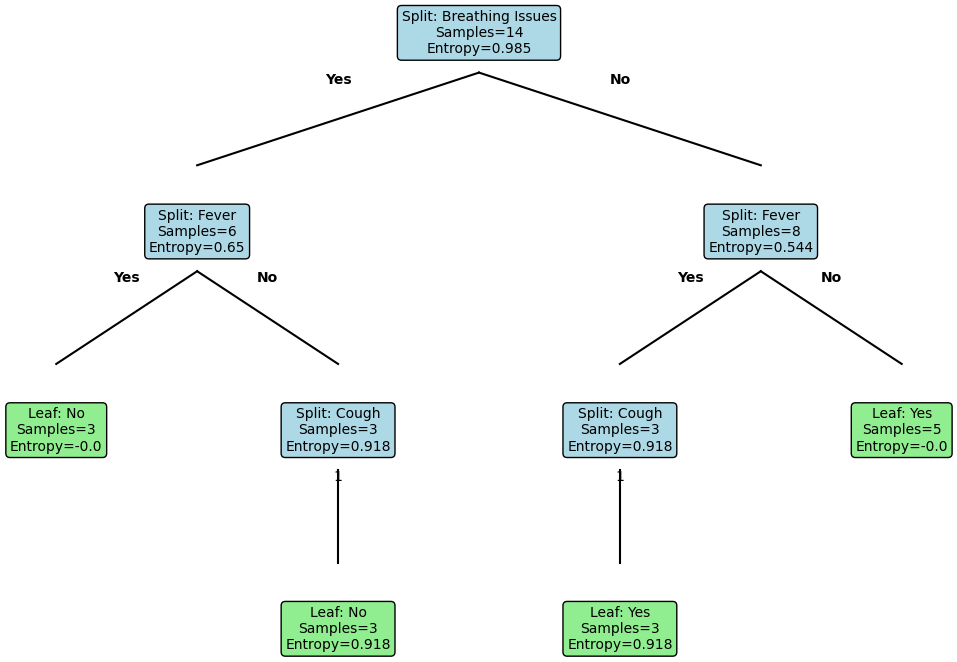

In [ ]:
def plot_decision_tree(tree, X, y, x=0.5, y_pos=1, dx=0.25, dy=0.15, ax=None, depth=0):
    class_map = {0: "No", 1: "Yes"}
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 7))
        ax.set_axis_off()

    if not isinstance(tree, dict):
        leaf_label = tree
        if class_map is not None:
            leaf_label = class_map.get(tree, tree)
        label = f"Leaf: {leaf_label}\nSamples={len(y)}\nEntropy={round(entropy(y), 3)}"
        ax.text(x, y_pos, label, ha='center', va='center',
                bbox=dict(boxstyle="round", facecolor="lightgreen"))
        return ax

    feature = next(iter(tree))
    label = f"Split: {feature}\nSamples={len(y)}\nEntropy={round(entropy(y), 3)}"
    ax.text(x, y_pos, label, ha='center', va='center',
            bbox=dict(boxstyle="round", facecolor="lightblue"))

    branches = tree[feature]
    n_children = len(branches)
    x_start = x - dx * (n_children - 1) / 2

    branch_labels = ["Yes", "No"]

    for i, (branch_val, subtree) in enumerate(branches.items()):
        child_x = x_start + i * dx
        child_y = y_pos - dy

        ax.plot([x, child_x], [y_pos - 0.03, child_y + 0.05], 'k-')

        if n_children == 2:
            label_x = (x + child_x) / 2
            label_y = (y_pos + child_y) / 2 + 0.04
            ax.text(label_x, label_y, branch_labels[i], ha='center', va='center', fontsize=10, fontweight='bold')
        else:
            label_x = (x + child_x) / 2
            label_y = (y_pos + child_y) / 2 + 0.04
            ax.text(label_x, label_y, str(branch_val), ha='center', va='center')

        mask = X[feature] == branch_val
        X_sub = X[mask].drop(columns=[feature])
        y_sub = y[mask]

        plot_decision_tree(subtree, X_sub, y_sub, child_x, child_y, dx / 2, dy, ax, depth + 1)

    return ax


plt.figure(figsize=(12, 7))
plot_decision_tree(decision_tree, X, y)
plt.show()

Cross-validation Accuracy Scores: [0.66666667 1.         1.         0.33333333 0.        ]
Mean Cross-validation Accuracy: 0.6

Confusion Matrix:
[[0 0]
 [0 3]]

Accuracy: 1.0

Decision Tree Rules:

|--- Breathing Issues <= 0.50
|   |--- class: 0
|--- Breathing Issues >  0.50
|   |--- class: 1



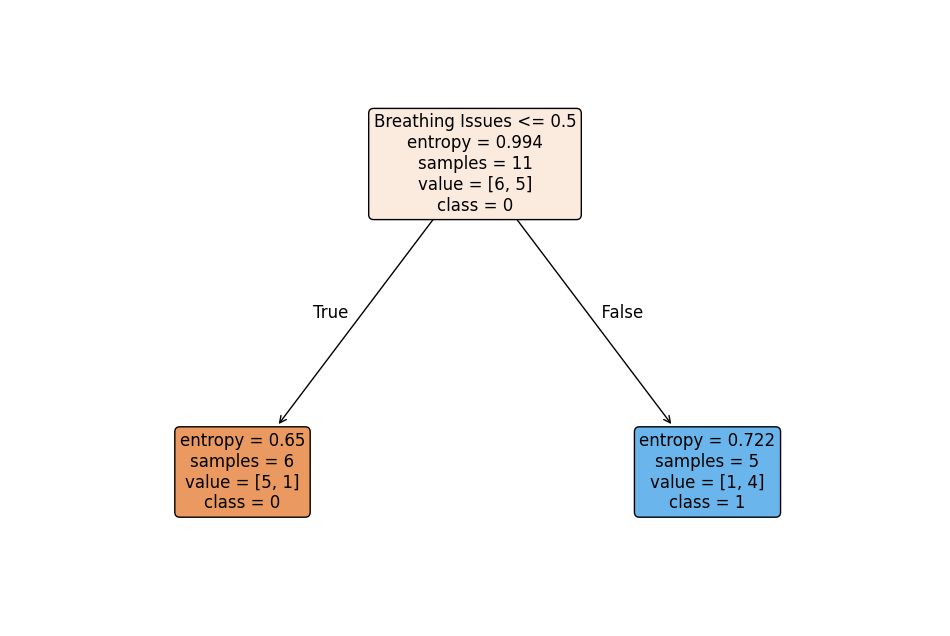

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

data = pd.read_csv("Infected_Data.csv")

X = data.drop(columns=['Infected'])
y = data['Infected']

X = X.apply(lambda col: col.astype('category').cat.codes if col.dtype == 'object' else col)
y = y.astype('category').cat.codes

clf = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=3,
    min_samples_leaf=5,
    random_state=0
)

cv_scores = cross_val_score(clf, X, y, cv=5)
print("Cross-validation Accuracy Scores:", cv_scores)
print("Mean Cross-validation Accuracy:", cv_scores.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred, labels=[0,1]))

print("\nAccuracy:", accuracy_score(y_test, y_pred))

print("\nDecision Tree Rules:\n")
print(export_text(clf, feature_names=list(X.columns)))

plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=X.columns, class_names=[str(c) for c in clf.classes_],
          filled=True, rounded=True, fontsize=12)
plt.show()


Decision Tree on Iris Dataset

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris

iris = load_iris()
data = pd.DataFrame(data=iris.data, columns=iris.feature_names)
data['target'] = iris.target

X = data.drop(columns=['target'])
y = data['target']

In [ ]:
def build_tree_iris(X, y, depth=0):
    indent = "  " * depth
    classes = dict(Counter(y))
    node_entropy = round(entropy(y), 3)
    print(f"{indent}Samples: {len(y)}, Classes: {classes}, Entropy: {node_entropy}")

    if len(np.unique(y)) == 1:
        print(f"{indent}--> Leaf: Class {y.iloc[0]}")
        return y.iloc[0]

    if X.shape[1] == 0:
        majority_class = Counter(y).most_common(1)[0][0]
        print(f"{indent}--> Leaf: Majority Class {majority_class}")
        return majority_class

    gains = [information_gain(y, X[col]) for col in X.columns]
    best_feature = X.columns[np.argmax(gains)]
    print(f"{indent}Split on '{best_feature}'")

    tree = {best_feature: {}}
    for val in np.unique(X[best_feature]):
        print(f"{indent}Branch {best_feature} = {val}:")
        mask = X[best_feature] == val
        subtree = build_tree_iris(X[mask].drop(columns=[best_feature]), y[mask], depth + 1)
        tree[best_feature][val] = subtree

    return tree

In [ ]:
def print_tree_iris(tree, indent=""):
    if not isinstance(tree, dict):
        print(indent + "-> " + str(tree))
        return

    for feature, branches in tree.items():
        print(indent + feature + "?")
        for val, subtree in branches.items():
            print(indent + f"|-- {val}")
            print_tree_iris(subtree, indent + "    ")

In [ ]:
iris_decision_tree = build_tree_iris(X, y)
print_tree_iris(iris_decision_tree)

Samples: 150, Classes: {0: 50, 1: 50, 2: 50}, Entropy: 1.585
Split on 'petal length (cm)'
Branch petal length (cm) = 1.0:
  Samples: 1, Classes: {0: 1}, Entropy: -0.0
  --> Leaf: Class 0
Branch petal length (cm) = 1.1:
  Samples: 1, Classes: {0: 1}, Entropy: -0.0
  --> Leaf: Class 0
Branch petal length (cm) = 1.2:
  Samples: 2, Classes: {0: 2}, Entropy: -0.0
  --> Leaf: Class 0
Branch petal length (cm) = 1.3:
  Samples: 7, Classes: {0: 7}, Entropy: -0.0
  --> Leaf: Class 0
Branch petal length (cm) = 1.4:
  Samples: 13, Classes: {0: 13}, Entropy: -0.0
  --> Leaf: Class 0
Branch petal length (cm) = 1.5:
  Samples: 13, Classes: {0: 13}, Entropy: -0.0
  --> Leaf: Class 0
Branch petal length (cm) = 1.6:
  Samples: 7, Classes: {0: 7}, Entropy: -0.0
  --> Leaf: Class 0
Branch petal length (cm) = 1.7:
  Samples: 4, Classes: {0: 4}, Entropy: -0.0
  --> Leaf: Class 0
Branch petal length (cm) = 1.9:
  Samples: 2, Classes: {0: 2}, Entropy: -0.0
  --> Leaf: Class 0
Branch petal length (cm) = 3.0:
 

Cross-validation Accuracy Scores: [0.96666667 1.         0.86666667 0.86666667 1.        ]
Mean Cross-validation Accuracy: 0.9400000000000001

Confusion Matrix:
[[11  0  0]
 [ 0 13  0]
 [ 0  0  6]]

Accuracy: 1.0

Decision Tree Rules:

|--- petal width (cm) <= 0.80
|   |--- class: 0
|--- petal width (cm) >  0.80
|   |--- petal width (cm) <= 1.75
|   |   |--- petal length (cm) <= 4.95
|   |   |   |--- class: 1
|   |   |--- petal length (cm) >  4.95
|   |   |   |--- class: 2
|   |--- petal width (cm) >  1.75
|   |   |--- sepal length (cm) <= 5.95
|   |   |   |--- class: 2
|   |   |--- sepal length (cm) >  5.95
|   |   |   |--- class: 2



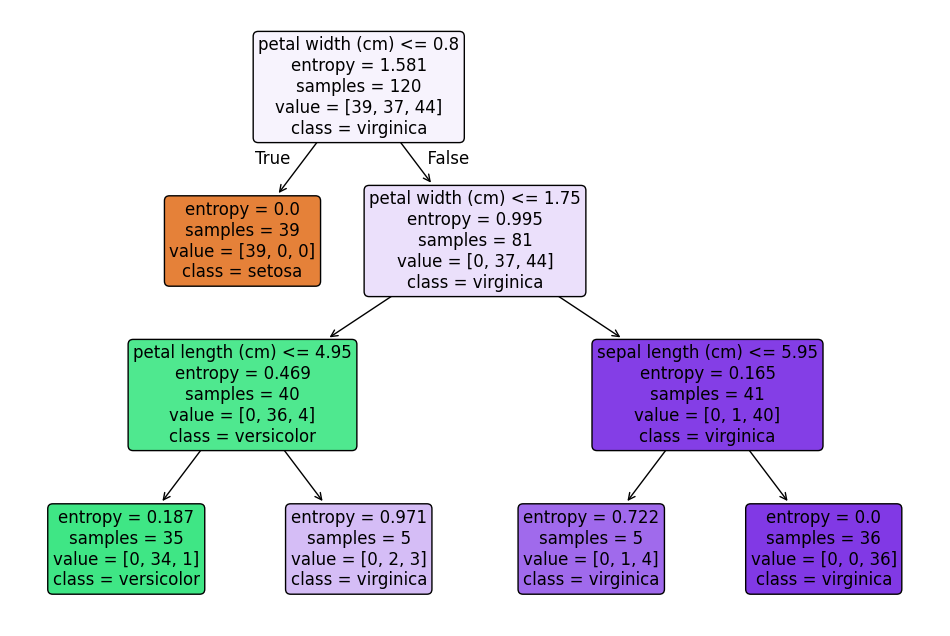

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score

clf = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=3,
    min_samples_leaf=5,
    random_state=0
)

cv_scores = cross_val_score(clf, X, y, cv=5)
print("Cross-validation Accuracy Scores:", cv_scores)
print("Mean Cross-validation Accuracy:", cv_scores.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred, labels=[0, 1, 2]))

print("\nAccuracy:", accuracy_score(y_test, y_pred))

print("\nDecision Tree Rules:\n")
print(export_text(clf, feature_names=list(X.columns)))

plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=X.columns, class_names=iris.target_names,
          filled=True, rounded=True, fontsize=12)
plt.show()